# Import libraries

In [4]:
pip install adjustText

In [5]:
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator
from scipy.stats import percentileofscore
from adjustText import adjust_text

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Get data

In [7]:
# creating list of gameweeks
gameweeks = []
for x in range(39):
  gameweeks.append(x)

In [8]:
# static store of .json for all league information
# The ‘bootstrap-static’ call returns a huge amouth of information, and is all you really need if you don’t want to get into specific FPL managed teams.

# Data included:

# A summary of all 38 gameweeks
# The game’s settings
# Basic information on all 20 PL teams
# Total number of FPL Users and overall chip usage
# Basic information on all Premier League players
# List of stats that FPL keeps track of
# The different FPL positions

static = requests.get("https://fantasy.premierleague.com/api/bootstrap-static/").json()

# Create tables

## Fixtures

In [9]:
# get fixtures data

def get_fixtures(link): # this function takes a link and produces a dataframe
  fixtures = pd.DataFrame(requests.get(link).json())
  return fixtures

In [10]:
# create fixtures dataframe
fixtures_link = "https://fantasy.premierleague.com/api/fixtures/"
fixtures = get_fixtures(fixtures_link)
fixtures.head()

,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2367818,NaN,False,False,281,None,0,True,None,7,NaN,1,NaN,[],3,4,93601
1,2367819,NaN,False,False,282,None,0,True,None,13,NaN,5,NaN,[],5,3,93602
2,2367792,NaN,False,False,255,None,0,True,None,18,NaN,7,NaN,[],3,3,93575
3,2367821,NaN,False,False,284,None,0,True,None,15,NaN,8,NaN,[],3,2,93604
4,2367822,NaN,False,False,285,None,0,True,None,11,NaN,9,NaN,[],4,2,93605


## Standings

In [11]:
# get standings data

def get_standings(league_id):
  link = "https://fantasy.premierleague.com/api/leagues-classic/" + str(league_id) + "/standings"
  standings = requests.get(link).json()
  standings_df = pd.DataFrame(standings['standings']['results'])[['entry','id','entry_name','player_name','event_total','total','rank','last_rank','rank_sort']]
  standings_df['point_differential'] = standings_df['total'] - standings_df['total'].max()
  standings_df['rank_change'] = standings_df['last_rank'] - standings_df['rank']
  team_ids = standings_df['entry'].tolist()
  return standings_df, team_ids

In [12]:
# create standings dataframe and list of team_ids
league_id = 1028900
standings, team_ids = get_standings(league_id)

In [13]:
standings.head()

,entry,id,entry_name,player_name,event_total,total,rank,last_rank,rank_sort,point_differential,rank_change
0,6800748,55767214,EgyptianKing'sCourt,Trustin Varnado,70,1636,1,2,1,0,1
1,4604344,35424675,haaland oates,Audax Bufete,33,1617,2,1,2,-19,-1
2,5730519,45332593,Holy Boehly,Darian Diaz,46,1442,3,3,3,-194,0
3,4755074,36723693,calcio e pepe,Claudio Castro,49,1437,4,4,4,-199,0
4,5833459,46212148,European On Me,warren ogle,44,1423,5,5,5,-213,0


## EPL Teams

In [14]:
# get epl team data

def get_epl_teams(drop_columns, static):
  epl_teams = pd.DataFrame(static['teams']).drop(columns=drop_columns)
  return epl_teams

In [15]:
# epl teams table
drop_columns=[
    'position',
    'team_division',
    'unavailable'
]
epl_teams = get_epl_teams(drop_columns, static)

In [16]:
epl_teams.head()

,code,draw,form,id,loss,name,played,points,short_name,strength,win,strength_overall_home,strength_overall_away,strength_attack_home,strength_attack_away,strength_defence_home,strength_defence_away,pulse_id
0,3,0,None,1,0,Arsenal,0,0,ARS,4,0,1220,1260,1270,1280,1170,1240,1
1,7,0,None,2,0,Aston Villa,0,0,AVL,3,0,1130,1235,1120,1220,1130,1250,2
2,91,0,None,3,0,Bournemouth,0,0,BOU,3,0,1095,1100,1070,1120,1130,1110,127
3,94,0,None,4,0,Brentford,0,0,BRE,3,0,1120,1155,1120,1130,1120,1180,130
4,36,0,None,5,0,Brighton,0,0,BHA,3,0,1130,1185,1100,1120,1160,1250,131


## Gameweek Stats

In [17]:
# extract team (entry) stats for each gameweek (event)

def get_gameweek_stats(team_ids):
  gw_stats = pd.DataFrame()
  for j in team_ids:
    df=pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/entry/"+str(j)+"/history/").json()['current'])
    df['entry'] = j
    gw_stats=pd.concat([gw_stats, df], ignore_index=True)
  gw_stats['event'] = gw_stats['event'].astype(int)
  gw_stats['rank'] = gw_stats.groupby(['event'])['total_points'].rank(method='first',ascending=False).astype(int)
  gw_stats['value'] = gw_stats['value'].astype(int) / 10
  return gw_stats

In [18]:
# create gw_stats dataframe for all results
gw_stats = get_gameweek_stats(team_ids)
gw_stats.head()

,event,points,total_points,rank,rank_sort,overall_rank,percentile_rank,bank,value,event_transfers,event_transfers_cost,points_on_bench,entry
0,1,71,71,3,2866449,2641868,NaN,0,100.0,0,0,18,6800748
1,2,61,132,1,767710,812849,NaN,4,100.0,1,0,11,6800748
2,3,50,182,1,2546435,703074,NaN,4,100.7,0,0,8,6800748
3,4,88,270,1,885516,227004,NaN,2,100.7,2,0,9,6800748
4,5,44,314,1,5166147,298910,NaN,12,100.8,1,0,5,6800748


## Global FPL Table

In [19]:
# weekly FPL totals frome static events
FPL_totals = pd.DataFrame(static['events']).drop(columns=[
    'deadline_time',
    'deadline_time_epoch',
    'deadline_time_game_offset',
    'h2h_ko_matches_created',
    'highest_scoring_entry',
    'is_previous',
    'is_current',
    'is_next',
    'cup_leagues_created'
])

# only keep weeks that are finished scoring
FPL_totals = FPL_totals[FPL_totals.finished==True]

# store the latest week global average score
FPL_avg_score = FPL_totals.iloc[-1]['average_entry_score']

In [20]:
FPL_totals.tail()

,id,name,release_time,average_entry_score,finished,data_checked,highest_score,ranked_count,chip_plays,most_selected,most_transferred_in,top_element,top_element_info,transfers_made,most_captained,most_vice_captained
21,22,Gameweek 22,None,48,True,True,128.0,10564383,"[{'chip_name': 'bboost', 'num_played': 63489},...",19.0,349.0,757.0,"{'id': 757, 'points': 21}",10103114,355.0,19.0
22,23,Gameweek 23,None,57,True,True,142.0,10575742,"[{'chip_name': 'bboost', 'num_played': 60492},...",355.0,355.0,353.0,"{'id': 353, 'points': 20}",6462542,355.0,19.0
23,24,Gameweek 24,None,62,True,True,131.0,10599683,"[{'chip_name': 'bboost', 'num_played': 62754},...",355.0,294.0,540.0,"{'id': 540, 'points': 17}",9398962,355.0,19.0
24,25,Gameweek 25,None,73,True,True,162.0,10623051,"[{'chip_name': 'bboost', 'num_played': 157972}...",355.0,355.0,304.0,"{'id': 304, 'points': 17}",15083938,355.0,349.0
25,26,Gameweek 26,None,46,True,True,128.0,10648230,"[{'chip_name': 'bboost', 'num_played': 17362},...",355.0,557.0,526.0,"{'id': 526, 'points': 20}",15159296,355.0,19.0


## Position Key

In [21]:
positions = pd.DataFrame(static['element_types']).drop(columns=[
    'plural_name',
    'plural_name_short',
    'ui_shirt_specific',
    'sub_positions_locked'
])

positions

,id,singular_name,singular_name_short,squad_select,squad_min_play,squad_max_play,element_count
0,1,Goalkeeper,GKP,2,1,1,94
1,2,Defender,DEF,5,3,5,268
2,3,Midfielder,MID,5,2,5,362
3,4,Forward,FWD,3,1,3,108


## Squads

In [24]:
def get_squads(team_ids, current_week):
  squads = pd.DataFrame()
  for i in range(1,current_week+1):
    for j in team_ids:
      x = requests.get("https://fantasy.premierleague.com/api/entry/"+str(j)+"/event/"+str(i)+"/picks/").json()
      df=pd.DataFrame(x['picks'])
      df['entry'] = j
      df['event'] = i
      squads=pd.concat([squads,df])
  return squads

In [25]:
current_week = gw_stats['event'].max()

squads = get_squads(team_ids,current_week)

In [26]:
squads.head()

,element,position,multiplier,is_captain,is_vice_captain,entry,event
0,230,1,1,False,True,6800748,1
1,290,2,1,False,False,6800748,1
2,584,3,1,False,False,6800748,1
3,20,4,1,False,False,6800748,1
4,585,5,1,False,False,6800748,1


## Weekly Player Stats

In [27]:
def get_player_stats(current_week):
  player_stats = pd.DataFrame()
  for i in range(1,current_week+1):
    df=pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/event/"+str(i)+"/live/").json())
    df['week'] = i
    for key in df['elements'][0].keys():
      df[key] = df['elements'].apply(lambda x: x[key])
    for key in df['elements'][0]['stats'].keys():
      df[key] = df['stats'].apply(lambda x: x[key])
    player_stats = pd.concat([player_stats,df])
  player_stats = player_stats.drop(columns=['elements','stats','explain'])
  return player_stats

In [28]:
player_stats = get_player_stats(current_week)
player_stats.head()

,week,id,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,total_points,in_dreamteam
0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False
1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False
2,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False
3,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,0,False
4,1,5,4,0,0,0,0,0,0,0,0,0,0,0,2,0.2,0.0,0.0,0.0,0,0.00,0.00,0.00,0.02,1,False


## Player Summary

In [29]:
# player stats and info
players = pd.DataFrame(static['elements'])

float_convert_list = [
    'selected_by_percent',
    'value_form',
    'value_season',
    'influence',
    'creativity',
    'threat',
    'ict_index',
    'form',
    'points_per_game',
    'expected_assists',
    'expected_goals',
    'expected_goal_involvements',
    'expected_goals_conceded'
]

for x in float_convert_list:
  players[x] = players[x].astype(float)

In [30]:
players.head()

,chance_of_playing_next_round,chance_of_playing_this_round,code,cost_change_event,cost_change_event_fall,cost_change_start,cost_change_start_fall,dreamteam_count,element_type,ep_next,ep_this,event_points,first_name,form,id,in_dreamteam,news,news_added,now_cost,photo,points_per_game,second_name,selected_by_percent,special,squad_number,status,team,team_code,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,minutes,goals_scored,assists,clean_sheets,goals_conceded,own_goals,penalties_saved,penalties_missed,yellow_cards,red_cards,saves,bonus,bps,influence,creativity,threat,ict_index,starts,expected_goals,expected_assists,expected_goal_involvements,expected_goals_conceded,influence_rank,influence_rank_type,creativity_rank,creativity_rank_type,threat_rank,threat_rank_type,ict_index_rank,ict_index_rank_type,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,direct_freekicks_order,direct_freekicks_text,penalties_order,penalties_text,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,now_cost_rank,now_cost_rank_type,form_rank,form_rank_type,points_per_game_rank,points_per_game_rank_type,selected_rank,selected_rank_type,starts_per_90,clean_sheets_per_90
0,0.0,0.0,232223,0,0,-1,1,0,4,0.0,0.0,0,Folarin,0.0,1,False,Transferred to Monaco,2023-08-31T08:55:15.272751Z,44,232223.jpg,0.0,Balogun,0.2,False,None,u,1,3,0,10024,0,63149,19,0.0,0.0,Balogun,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,0.00,0.00,0.00,0.00,675,68,667,69,641,66,678,70,NaN,,NaN,,NaN,,0.00,0.0,0.00,0.00,0.00,0.00,552,101,599,54,687,74,335,53,0.00,0.00
1,NaN,NaN,58822,0,0,-2,2,0,2,0.9,1.4,0,Cédric,0.4,2,False,,None,38,58822.jpg,1.0,Alves Soares,0.4,False,None,a,1,3,2,40608,695,47937,242,0.1,0.5,Cédric,34,0,0,0,0,0,0,0,0,0,0,0,6,1.0,2.0,0.0,0.3,0,0.00,0.01,0.01,0.28,516,186,462,169,468,169,514,184,NaN,,NaN,,NaN,,0.00,0.0,0.03,0.03,0.74,0.00,826,264,325,113,434,152,261,100,0.00,0.00
2,100.0,100.0,153256,0,0,-1,1,0,3,0.9,1.4,0,Mohamed,0.4,3,False,,2023-12-30T22:30:09.113694Z,44,153256.jpg,2.0,Elneny,0.1,False,None,a,1,3,6,13314,11,19886,23,0.1,1.4,M.Elneny,25,0,1,0,0,0,0,0,0,0,0,0,16,4.0,2.1,10.0,1.6,0,0.08,0.01,0.09,0.13,498,224,460,226,426,212,494,225,NaN,,NaN,,NaN,,0.29,0.0,0.04,0.33,0.47,0.00,525,310,331,153,301,127,468,157,0.00,0.00
3,100.0,100.0,438098,0,0,-1,1,0,3,0.5,1.0,0,Fábio,0.0,4,False,,2023-12-07T12:00:08.489004Z,54,438098.jpg,2.6,Ferreira Vieira,0.1,False,None,a,1,3,21,11561,9,18898,13,0.0,3.9,Fábio Vieira,236,1,3,1,2,0,0,0,0,1,0,0,62,79.4,63.6,77.0,21.9,2,1.20,0.35,1.55,1.48,372,156,315,169,259,136,356,159,NaN,,NaN,,4.0,,0.46,0.0,0.13,0.59,0.56,0.76,125,77,806,349,214,89,448,148,0.76,0.38
4,100.0,100.0,226597,0,0,3,-3,3,2,4.3,4.8,0,Gabriel,3.8,5,False,,2024-01-20T15:30:09.437664Z,53,226597.jpg,4.0,dos Santos Magalhães,27.1,False,None,a,1,3,96,2714297,16961,2821735,3635,0.7,18.1,Gabriel,1994,3,1,8,20,1,0,0,2,0,0,6,435,503.0,93.5,289.0,88.7,22,3.11,0.45,3.56,16.51,58,20,264,75,88,4,113,21,NaN,,NaN,,NaN,,0.14,0.0,0.02,0.16,0.75,0.90,146,15,59,11,47,5,9,3,0.99,0.36


## Player Position Bridge

In [34]:
player_positions = players[['element_type','id','first_name','second_name','web_name']].merge(positions[['id','singular_name']], how='inner',left_on='element_type',right_on='id').drop(columns=['element_type','id_y'])
player_positions.columns = ['player_id','first_name','second_name','web_name','position']
player_positions

,player_id,first_name,second_name,web_name,position
0,1,Folarin,Balogun,Balogun,Forward
1,8,Gabriel,Fernando de Jesus,G.Jesus,Forward
2,13,Eddie,Nketiah,Nketiah,Forward
3,39,Keinan,Davis,Davis,Forward
4,44,Jhon,Durán,Duran,Forward
...,...,...,...,...,...
827,647,Joseph,Anang,Anang,Goalkeeper
828,546,Daniel,Bentley,Bentley,Goalkeeper
829,564,Tom,King,King,Goalkeeper
830,569,José,Malheiro de Sá,José Sá,Goalkeeper


# Visuals

## Standings

In [ ]:
data=standings[['rank','rank_change','entry_name', 'player_name','event_total','total','point_differential']]
data.columns = ['Place', 'Place Change','Team Name','Manager','Gameweek Points','Total Points','Total Point Differential']
data

,Place,Place Change,Team Name,Manager,Gameweek Points,Total Points,Total Point Differential
0,1,0,haaland oates,Audax Bufete,51,1592,0
1,2,0,EgyptianKing'sCourt,Trustin Varnado,60,1566,-26
2,3,0,Holy Boehly,Darian Diaz,57,1404,-188
3,4,1,calcio e pepe,Claudio Castro,69,1388,-204
4,5,1,European On Me,warren ogle,65,1379,-213
5,6,1,urBVB,John Urbano,51,1367,-225
6,7,-3,Siete_para_siempre,Cesar Castro,33,1354,-238
7,8,0,Danny Drankwater,alexander tejada,19,1267,-325
8,9,0,ASM Gucci Heabands,Emerson Tejada,26,1259,-333
9,10,0,Pochettino's PL Pals,Ian Barker,40,1255,-337


## Standings by week

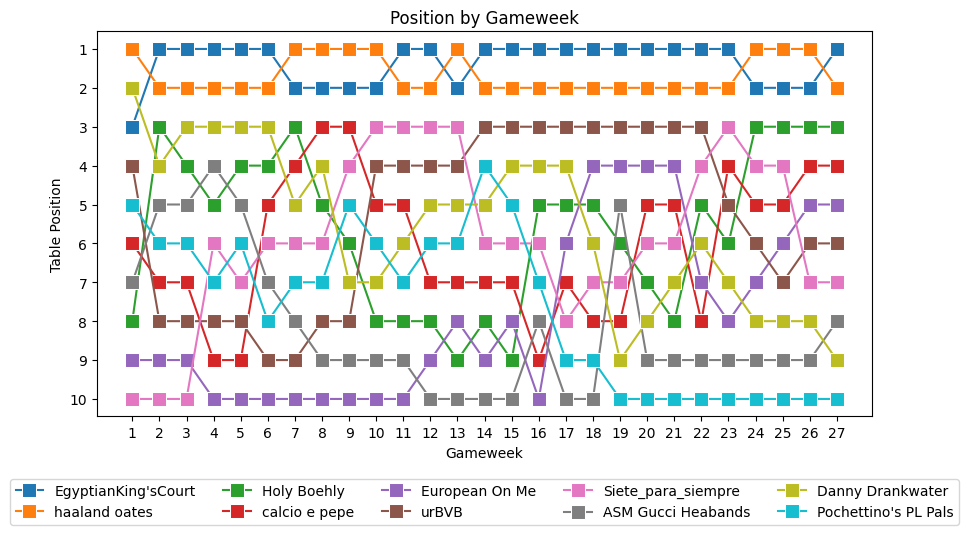

In [35]:
data=pd.merge(
      gw_stats[['entry','event','rank']],
      standings[['entry','entry_name']],
      on='entry'
)

plt.figure(figsize=(10,5))

sns.lineplot(
    data=data,
    x='event',
    y='rank',
    hue='entry_name',
    markers=True,
    marker='s',
    markersize=10
)

plt.yticks([x for x in range(1,11)])
plt.xlabel('Gameweek')
plt.xticks(range(data['event'].min(), data['event'].max()+1))
plt.ylabel('Table Position')
plt.gca().invert_yaxis()
plt.title('Position by Gameweek')

plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,-0.30),
    ncol=5
)

## Squad Value

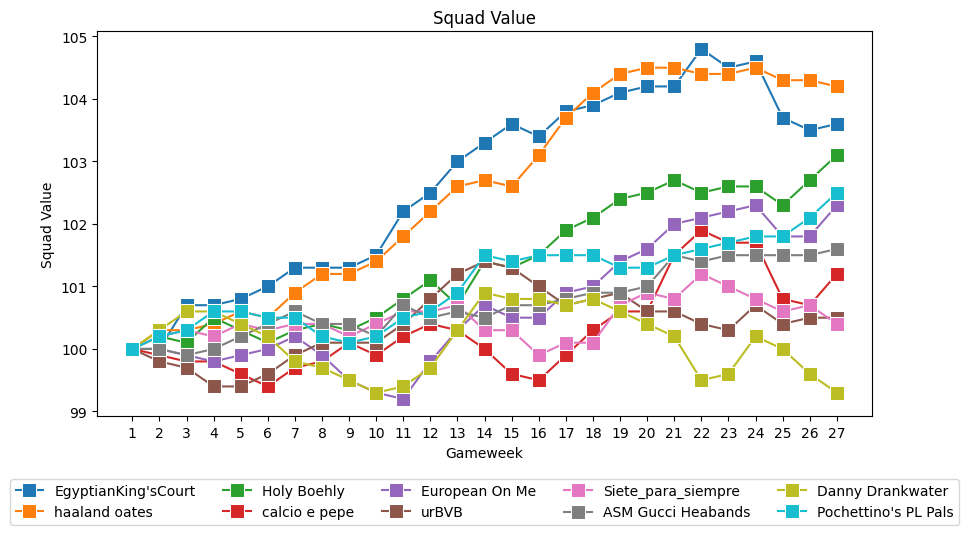

In [37]:
data = pd.merge(
      gw_stats[['entry','event','value']],
      standings[['entry','entry_name']],
      on='entry'
)

plt.figure(figsize=(10,5))

sns.lineplot(
    data=data,
    x='event',
    y='value',
    hue='entry_name',
    markers=True,
    marker='s',
    markersize=10
)

plt.xlabel('Gameweek')
plt.xticks(range(data['event'].min(), data['event'].max()+1))
plt.ylabel('Squad Value')
plt.title('Squad Value')

plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,-0.30),
    ncol=5
)

## Points Behind 1st

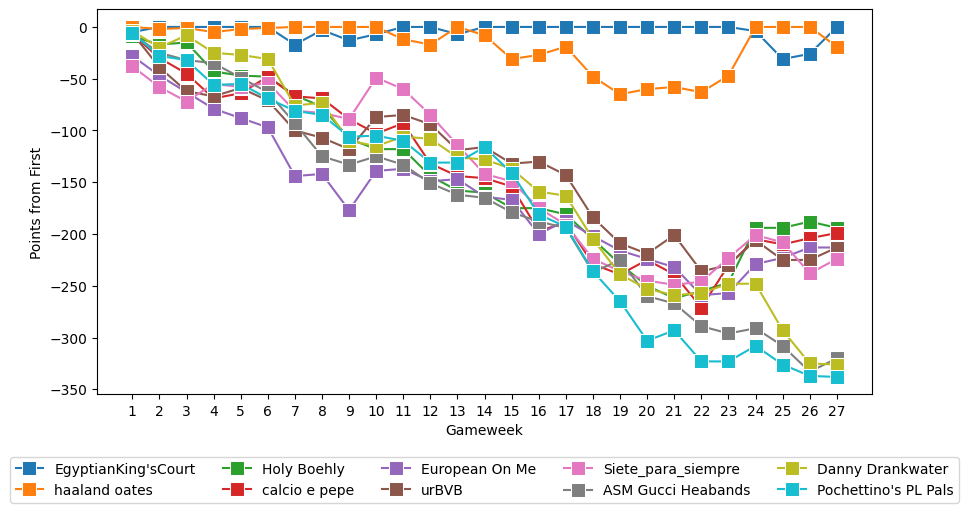

In [39]:
# get entry name on the gw_stats df
data=pd.merge(
      gw_stats[['entry','event','total_points']],
      standings[['entry','entry_name']],
      on='entry'
  )

# create a point differential from the leader each week by team
data['pt_diff'] = data['total_points'] - data.groupby(['event'])['total_points'].transform('max')
plt.figure(figsize=(10,5))

sns.lineplot(
    data=data,
    x='event',
    y='pt_diff',
    hue='entry_name',
    markers=True,
    marker='s',
    markersize=10
)

plt.xlabel('Gameweek')
plt.ylabel('Points from First')
plt.xticks(range(data['event'].min(), data['event'].max()+1))
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,-0.30),
    ncol=5
)

## Weekly Average Scores

<ipython-input-40-d09c92ee5a4f>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['entry_name'] = 'FPL Average'


Text(0.5, 1.0, 'Weekly Points')

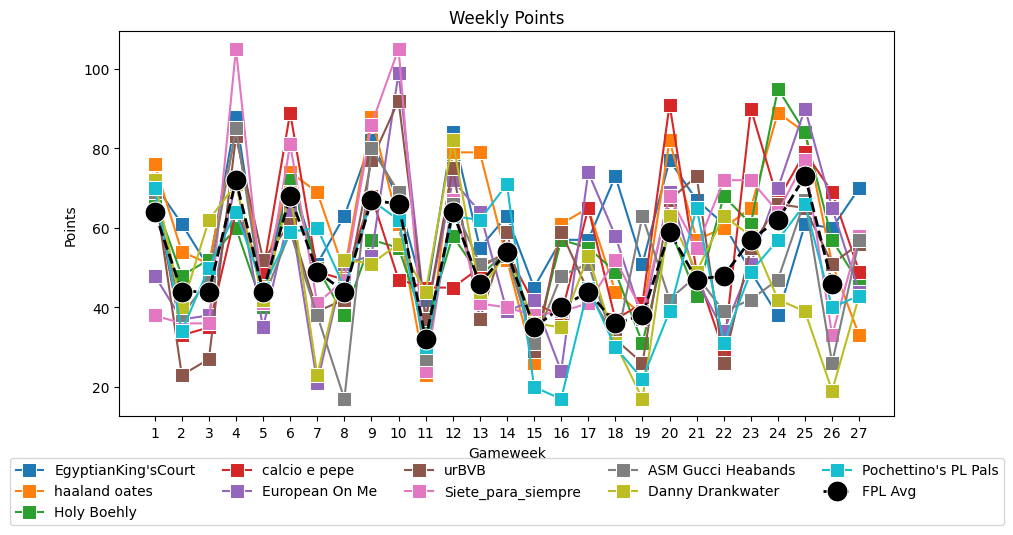

In [40]:
# adding entry name to gw_stats
data=pd.merge(
      gw_stats[['entry','event','points']],
      standings[['entry','entry_name']],
      on='entry'
  )

# creating df for weekly average global scores
data2=FPL_totals[['id','average_entry_score','name']]
data2.columns=['entry','points','entry_name']
data2['entry_name'] = 'FPL Average'

plt.figure(figsize=(10,5))

# plot gw_stat scores
sns.lineplot(
    data=data,
    x='event',
    y='points',
    hue='entry_name',
    markers=True,
    marker='s',
    markersize=10
)

# plot fpl weekly global average
sns.lineplot(
    x=data['event'],
    y=data2['points'],
    linestyle='--',
    marker='o',
    label='FPL Avg',
    color='black',
    markersize = 15,
    linewidth=2
)

plt.xlabel('Gameweek')
plt.ylabel('Points')
plt.xticks(range(data['event'].min(), data['event'].max()+1))
plt.legend(
    loc='lower center',
    bbox_to_anchor=(0.5,-0.30),
    ncol=5
)
plt.title('Weekly Points')

## TOTWs

In [ ]:
data = pd.merge(squads[['element','event','entry']], player_stats[player_stats.in_dreamteam == True][['week','id','in_dreamteam']], how='inner',left_on=['element','event'], right_on=['id','week'])
data = pd.merge(data[['week','entry','in_dreamteam']].groupby(['week','entry']).count().reset_index(), standings[['entry','entry_name']], how='inner', on='entry')
data = data.drop(columns=['entry'])
data.columns = ['week','totws','entry_name']

Text(0, 0.5, '')

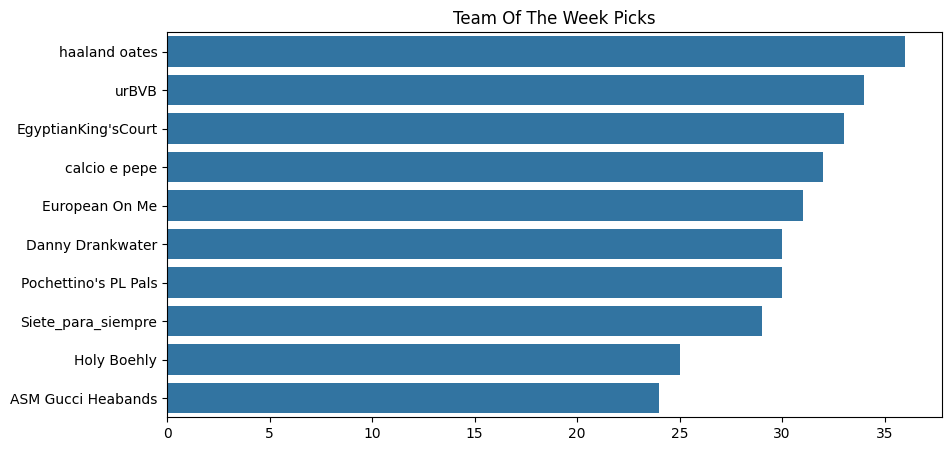

In [ ]:
plt.figure(figsize=(10,5))

sns.barplot(
    data = data[['entry_name','totws']].groupby('entry_name').sum().sort_values('totws', ascending=False).reset_index(),
    x='totws',
    y='entry_name'
)

plt.title('Team Of The Week Picks')
plt.xlabel('')
plt.ylabel('')

## Players Below FPL Global Average

In [42]:
data = standings[standings.event_total < FPL_avg_score][['rank','entry_name', 'player_name','event_total']].sort_values('event_total', ascending=False)
data['diff'] = data['event_total'] - FPL_avg_score
data.columns = ['rank', 'team', 'manager', 'week_score', 'vs_avg']
data

,rank,team,manager,week_score,vs_avg
4,5,European On Me,warren ogle,44,-2
8,9,Danny Drankwater,alexander tejada,43,-3
9,10,Pochettino's PL Pals,Ian Barker,43,-3
1,2,haaland oates,Audax Bufete,33,-13


## Team Score Boxplot

Text(0, 0.5, 'Points')

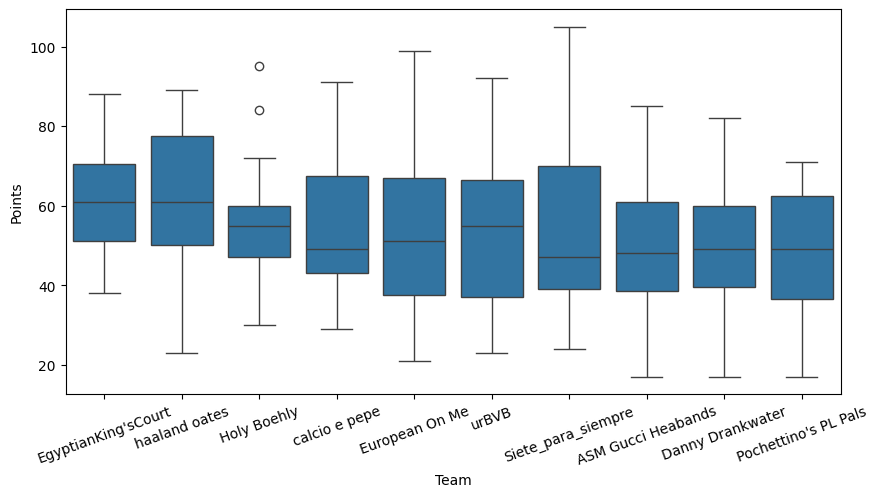

In [43]:
data=pd.merge(
      gw_stats[['entry','event','points']],
      standings[['entry','entry_name']],
      on='entry'
  )

plt.figure(figsize=(10,5))

sns.boxplot(
    data=data,
    x='entry_name',
    y='points'
)

plt.xticks(rotation=20)
plt.xlabel('Team')
plt.ylabel('Points')

## Player Value

## Top Player Shortlist

using the following features to create the shortlist:

- form
  - goal involvements
  - xgi
  - clean sheets (defenders)
  - bonus points
- fixtures

### Fixture Difficulty

In [44]:
a = players[['id','first_name','second_name','web_name','element_type','team','team_code','now_cost','selected_by_percent','form','value_season','value_form','total_points','bonus','minutes','goals_scored','assists','clean_sheets','goals_conceded','yellow_cards','saves','ict_index','starts','expected_goal_involvements','expected_goals_conceded','corners_and_indirect_freekicks_order','direct_freekicks_order','penalties_order','expected_goal_involvements_per_90','saves_per_90','expected_goals_conceded_per_90','goals_conceded_per_90','clean_sheets_per_90']]

players_df = pd.merge(
    a,
    positions[['id','singular_name']],
    left_on='element_type',
    right_on='id'
).drop(columns=['id_y']).rename(columns={'id_x':'id'})


fixtures_df = pd.merge(
    epl_teams[['code','id','name','strength','strength_overall_home','strength_overall_away','strength_attack_home','strength_attack_away','strength_defence_home','strength_defence_away']],
    fixtures[(fixtures.event>current_week)&(fixtures.event<=current_week+5)][['team_a','team_h','team_a_difficulty']].groupby('team_a').agg({'team_h':'count','team_a_difficulty':'sum'}).sort_values('team_a').reset_index(),
    left_on='id',
    right_on='team_a'
).drop(columns=['team_a']).rename(columns={'team_h':'away_games','team_a_difficulty':'away_difficulty'})

fixtures_df = fixtures_df.merge(
    fixtures[(fixtures.event>current_week)&(fixtures.event<=current_week+5)][['team_h','team_a','team_h_difficulty']].groupby('team_h').agg({'team_a':'count','team_h_difficulty':'sum'}).sort_values('team_h').reset_index(),
    left_on='id',
    right_on='team_h'
).drop(columns=['team_h']).rename(columns={'team_a':'home_games','team_h_difficulty':'home_difficulty'})

fixtures_df['total_games_next_five'] = fixtures_df['away_games'] + fixtures_df['home_games']
fixtures_df['total_difficulty_next_five'] = fixtures_df['away_difficulty'] + fixtures_df['home_difficulty']
fixtures_df['adj_away_difficulty'] = fixtures_df['away_difficulty'] * 1.22
fixtures_df['adj_total_difficulty_next_five'] = fixtures_df['adj_away_difficulty'] + fixtures_df['home_difficulty']

shortlist = pd.merge(
    players_df[['team','first_name','second_name','web_name','singular_name','now_cost','selected_by_percent','form','value_form','total_points','value_season','bonus','minutes','goals_scored','assists','clean_sheets','goals_conceded','yellow_cards','saves','ict_index','expected_goal_involvements','expected_goals_conceded','corners_and_indirect_freekicks_order','direct_freekicks_order','penalties_order']],
    fixtures_df[['id','name','strength','away_games','away_difficulty','home_games','home_difficulty','total_games_next_five','total_difficulty_next_five','adj_away_difficulty','adj_total_difficulty_next_five']],
    left_on='team',
    right_on='id'
).drop(columns=['team','id']).rename(columns={'name':'team_name'}).sort_values('total_points', ascending=False)

shortlist['goal_involvements'] = shortlist['goals_scored'] + shortlist['assists']

Text(0.5, 0, 'Adjusted Total Difficulty, Next Five Fictures')

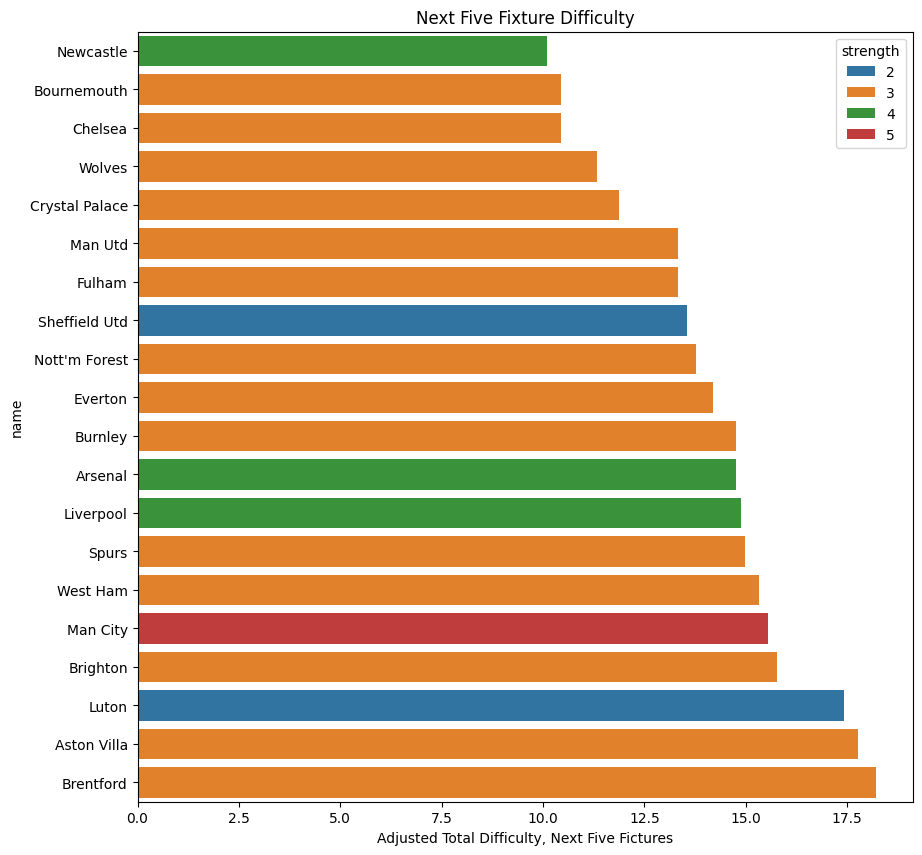

In [48]:
data = fixtures_df[['name','strength','adj_total_difficulty_next_five']].sort_values('adj_total_difficulty_next_five')

plt.figure(figsize=(10,10))

sns.barplot(
    data=data,
    x='adj_total_difficulty_next_five',
    y='name',
    # color = 'blue',
    hue='strength',
    dodge=False,
    palette='tab10'
)

plt.title('Next Five Fixture Difficulty')
plt.xlabel('Adjusted Total Difficulty, Next Five Fictures')

## Top 30 Players

In [ ]:
df=shortlist[['web_name','singular_name','team_name','now_cost','total_points','form','adj_total_difficulty_next_five']].sort_values('form',ascending=False).head(30).reset_index()
df['now_cost'] = df['now_cost'] / 10
df.columns = ['index','name','position','team','cost','total_points','form','fixture_difficulty']
df.drop(columns='index')

,name,position,team,cost,total_points,form,fixture_difficulty
0,Saka,Midfielder,Arsenal,9.2,169,12.2,13.54
1,Watkins,Forward,Aston Villa,8.9,170,10.5,17.20
2,Gross,Midfielder,Brighton,6.5,123,9.0,14.20
3,Havertz,Midfielder,Arsenal,7.1,89,8.2,13.54
4,Douglas Luiz,Midfielder,Aston Villa,5.6,130,8.0,17.20
5,Hudson-Odoi,Midfielder,Nott'm Forest,4.7,64,8.0,14.10
6,Muniz,Forward,Fulham,4.5,43,7.8,13.32
7,Dunk,Defender,Brighton,5.1,60,7.8,14.20
8,Luis Díaz,Midfielder,Liverpool,7.5,97,7.6,12.44
9,Foden,Midfielder,Man City,8.1,143,7.5,16.10


Text(0.5, 1.0, 'Top Players by Position')

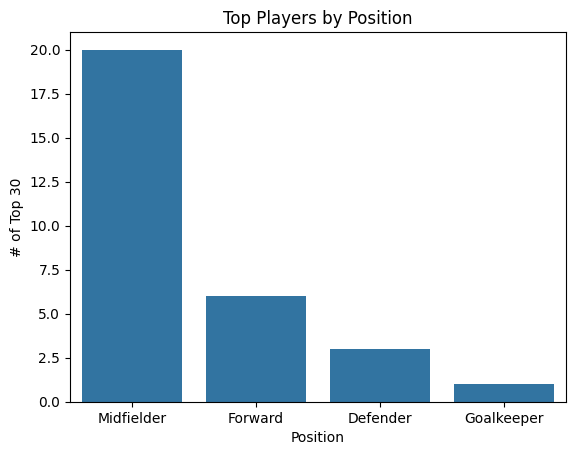

In [ ]:
data = df[['position','name']].groupby('position').count().sort_values('name', ascending=False).reset_index()
data['pc'] = data['name'] / data['name'].sum()

sns.barplot(
    data=data,
    x='position',
    y='name'
)

plt.xlabel('Position')
plt.ylabel('# of Top 30')
plt.title('Top Players by Position')

In [ ]:
data=df[['position','total_points']].groupby('position').sum().sort_values('total_points',ascending=False).reset_index()
data['pc'] = data['total_points'] / data['total_points'].sum()
data

,position,total_points,pc
0,Midfielder,2124,0.689610
1,Forward,666,0.216234
2,Defender,205,0.066558
3,Goalkeeper,85,0.027597


Text(0, 0.5, '% of All Points')

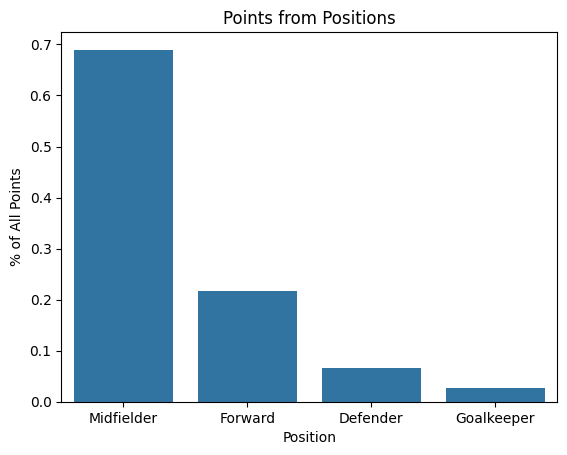

In [ ]:
sns.barplot(
    data=data,
    x='position',
    y='pc'
)

plt.title('Points from Positions')
plt.xlabel('Position')
plt.ylabel('% of All Points')

# Exploration

In [ ]:
selections = squads[['element','entry']].groupby('element').count().reset_index().sort_values('entry',ascending=False).merge(player_positions[['player_id','web_name','position']], how='inner', left_on='element', right_on='player_id')
selections = selections[['player_id','web_name','position','entry']]
selections['selections_percent'] = round(100 * selections['entry'] / (10 * current_week))
selections.columns = ['Player_ID','Player','Position','Selections', 'Selected_Percent']
selections.head()

,Player_ID,Player,Position,Selections,Selected_Percent
0,355,Haaland,Forward,227,87.0
1,524,Areola,Goalkeeper,126,48.0
2,19,Saka,Midfielder,119,46.0
3,412,Gordon,Midfielder,113,43.0
4,131,Estupiñan,Defender,113,43.0


In [ ]:
weekly_selections = squads[['element','event','entry']].groupby(['element','event']).agg({'entry':'count'}).sort_values(['event','entry'],ascending=[True,False]).reset_index()
weekly_selections['selection_percent'] = round(100 * weekly_selections['entry'] / 10)
weekly_selections.head()

,element,event,entry,selection_percent
0,355,1,9,90.0
1,19,1,4,40.0
2,131,1,4,40.0
3,430,1,4,40.0
4,5,1,3,30.0


In [ ]:
weekly_selections

,element,event,entry,selection_percent
0,355,1,9,90.0
1,19,1,4,40.0
2,131,1,4,40.0
3,430,1,4,40.0
4,5,1,3,30.0
...,...,...,...,...
1986,570,26,1,10.0
1987,571,26,1,10.0
1988,597,26,1,10.0
1989,664,26,1,10.0


In [ ]:
weekly_selections[['selection_percent','element']].groupby('selection_percent').count().sort_values('selection_percent',ascending=False).reset_index()

,selection_percent,element
0,100.0,12
1,90.0,6
2,80.0,10
3,70.0,25
4,60.0,39
5,50.0,63
6,40.0,108
7,30.0,162
8,20.0,438
9,10.0,1128


## Weekly Player Performance

### Defenders

In [ ]:
a = player_stats[player_stats.total_points>0][['id','total_points']]

a['blank'] = np.where(a['total_points']<=3, 1, 0)
a['return'] = np.where(((a['total_points']>3)&(a['total_points']<=9)),1,0)
a['haul'] = np.where(a['total_points']>9,1,0)
a = a.groupby('id').agg({'total_points':'sum','blank':'sum','return':'sum','haul':'sum'}).sort_values(['haul','return','blank'], ascending=[False,False,True]).reset_index()
a.head()

,id,total_points,blank,return,haul
0,308,167,5,8,8
1,19,169,7,12,6
2,355,146,6,8,6
3,362,124,11,5,6
4,516,142,11,5,6


In [ ]:
b = pd.merge(
      players[['id','first_name','second_name','web_name','team','element_type','now_cost','ict_index','expected_goal_involvements']],
      positions[['id','singular_name']],
      how='inner',
      left_on='element_type',
      right_on='id'
).drop(columns=['element_type','id_y'])
# b = players[['id','first_name','second_name','web_name','team','element_type','now_cost','ict_index','expected_goal_involvements']]
b.rename(columns={'id_x':'id'},inplace=True)
b.head()

,id,first_name,second_name,web_name,team,now_cost,ict_index,expected_goal_involvements,singular_name
0,1,Folarin,Balogun,Balogun,1,44,0.0,0.00,Forward
1,8,Gabriel,Fernando de Jesus,G.Jesus,1,78,121.3,7.31,Forward
2,13,Eddie,Nketiah,Nketiah,1,51,74.6,5.04,Forward
3,39,Keinan,Davis,Davis,2,49,0.0,0.00,Forward
4,44,Jhon,Durán,Duran,2,50,20.8,1.27,Forward


In [ ]:
c = pd.merge(
  a,
  b,
  how='inner',
  on='id'
)
c.head()

,id,total_points,blank,return,haul,first_name,second_name,web_name,team,now_cost,ict_index,expected_goal_involvements,singular_name
0,308,167,5,8,8,Mohamed,Salah,Salah,11,130,243.9,20.30,Midfielder
1,19,169,7,12,6,Bukayo,Saka,Saka,1,92,274.2,19.64,Midfielder
2,355,146,6,8,6,Erling,Haaland,Haaland,13,145,211.1,21.17,Forward
3,362,124,11,5,6,Cole,Palmer,Palmer,7,57,158.7,12.69,Midfielder
4,516,142,11,5,6,Son,Heung-min,Son,18,96,188.9,11.81,Midfielder


In [ ]:
c[c.singular_name=='Defender'][['web_name','now_cost','total_points','haul','return','expected_goal_involvements','ict_index']].head(20)

,web_name,now_cost,total_points,haul,return,expected_goal_involvements,ict_index
12,Trippier,69,108,4,6,7.47,179.2
14,Alexander-Arnold,85,103,3,9,6.49,143.1
18,Gabriel,53,97,3,6,3.56,88.7
39,Virgil,64,94,2,7,2.96,109.9
43,Udogie,49,68,2,6,4.27,96.6
49,Senesi,45,68,2,5,2.76,79.5
50,Burn,44,66,2,5,2.78,73.3
53,Walker,55,80,2,5,3.15,86.2
55,Andersen,47,82,2,5,2.63,106.6
56,Dalot,52,76,2,5,2.55,100.9


In [ ]:
c[c.singular_name=='Midfielder'][['web_name','now_cost','total_points','haul','return','expected_goal_involvements','ict_index']].head(20)

,web_name,now_cost,total_points,haul,return,expected_goal_involvements,ict_index
0,Salah,130,167,8,8,20.30,243.9
1,Saka,92,169,6,12,19.64,274.2
3,Palmer,57,124,6,5,12.69,158.7
4,Son,96,142,6,5,11.81,188.9
6,Gross,65,123,5,6,11.81,228.8
7,Douglas Luiz,56,130,5,6,9.95,168.5
8,Rodrigo,56,100,5,4,7.46,161.7
9,Ødegaard,85,116,5,3,11.22,202.1
10,Gordon,61,121,4,10,10.29,155.3
11,Foden,81,143,4,10,11.90,239.7


In [ ]:
c[c.singular_name=='Forward'][['web_name','now_cost','total_points','haul','return','expected_goal_involvements','ict_index']].head(20)

,web_name,now_cost,total_points,haul,return,expected_goal_involvements,ict_index
2,Haaland,145,146,6,8,21.17,211.1
5,Watkins,89,170,5,12,17.04,230.5
13,Solanke,71,128,3,10,15.99,195.3
16,Darwin,76,101,3,9,15.93,177.6
17,Morris,51,101,3,8,8.24,113.2
27,Højlund,71,78,3,3,6.60,104.4
29,Wood,48,75,3,2,5.74,92.8
31,J.Alvarez,66,124,2,11,14.49,215.3
33,Cunha,56,108,2,10,10.67,168.7
44,Isak,75,81,2,6,11.39,111.2


## League Owned

In [ ]:
players[players.total_points > 0][['id','web_name','first_name','second_name','now_cost','total_points','expected_goal_involvements','expected_goals','goals_scored','assists','ict_index']].sort_values('total_points',ascending=False).head()

,id,web_name,first_name,second_name,now_cost,total_points,expected_goal_involvements,expected_goals,goals_scored,assists,ict_index
64,60,Watkins,Ollie,Watkins,89,170,17.04,13.58,14,15,230.5
17,19,Saka,Bukayo,Saka,92,169,19.64,11.18,13,8,274.2
427,308,Salah,Mohamed,Salah,130,167,20.30,14.30,15,9,243.9
507,355,Haaland,Erling,Haaland,145,146,21.17,19.57,17,7,211.1
505,353,Foden,Phil,Foden,81,143,11.90,7.03,9,7,239.7


In [ ]:
squads.head()

,element,position,multiplier,is_captain,is_vice_captain,entry,event
0,597,1,1,False,False,4604344,1
1,391,2,1,False,False,4604344,1
2,405,3,1,False,False,4604344,1
3,20,4,1,False,False,4604344,1
4,130,5,1,False,False,4604344,1


In [ ]:
squads['player_count'] = squads.groupby(['event','element'])['entry'].transform('nunique')

In [ ]:
squads[squads.element==355]

,element,position,multiplier,is_captain,is_vice_captain,entry,event,player_count
10,355,11,2,True,False,4604344,1,9
9,355,10,2,True,False,6800748,1,9
8,355,9,2,True,False,5730519,1,9
9,355,10,3,True,False,4755074,1,9
8,355,9,2,True,False,5833459,1,9
...,...,...,...,...,...,...,...,...
9,355,10,2,True,False,5833459,26,9
8,355,9,2,True,False,5247879,26,9
8,355,9,2,True,False,4612480,26,9
10,355,11,2,True,False,4613856,26,9


In [ ]:
data = pd.merge(
    squads[['event','element','player_count']].groupby(['event','element']).max().reset_index(),
    players[['id','web_name','first_name','second_name','total_points']],
    left_on='element',
    right_on='id',
    how='inner'
).sort_values(['event','player_count'], ascending=[True,False])

In [ ]:
data

,event,element,player_count,id,web_name,first_name,second_name,total_points
709,1,355,9,355,Haaland,Erling,Haaland,146
83,1,19,4,19,Saka,Bukayo,Saka,169
264,1,131,4,131,Estupiñan,Pervis,Estupiñán,48
890,1,430,4,430,Trippier,Kieran,Trippier,107
3,1,5,3,5,Gabriel,Gabriel,dos Santos Magalhães,96
...,...,...,...,...,...,...,...,...
1986,26,261,1,261,Onana,Amadou,Onana,51
1987,26,301,1,301,Kelleher,Caoimhin,Kelleher,15
1988,26,388,1,388,Mainoo,Kobbie,Mainoo,31
1989,26,563,1,563,Kilman,Max,Kilman,69


In [ ]:
# unique players per week
data[['event','element']].groupby('event').nunique().sort_values(['event','element'], ascending=[True,False]).reset_index()

,event,element
0,1,89
1,2,91
2,3,87
3,4,83
4,5,82
5,6,80
6,7,79
7,8,80
8,9,81
9,10,75


In [ ]:
data[data.event==current_week][['event','web_name','player_count','total_points']]

,event,web_name,player_count,total_points
734,26,Haaland,9,146
108,26,Saka,7,169
289,26,Estupiñan,7,48
1713,26,Palmer,7,124
670,26,De Bruyne,6,31
...,...,...,...,...
1986,26,Onana,1,51
1987,26,Kelleher,1,15
1988,26,Mainoo,1,31
1989,26,Kilman,1,69
